In [45]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os

In [46]:
# Create directory to store plots.
if not os.path.exists('./img'):
    os.makedirs('./img')

In [47]:
# Seed for same randomness.
np.random.seed(seed=0)

In [48]:
class SimulatedAnnealing:
    def __init__(self, l, n_cities=12, grid_size=200, n_iter=1000) -> None:
        # Constant number of cities.
        self.n_cities = n_cities
        # Number of iterations for the markov chain.
        self.l = l
        # Size of the grid.
        self.GRID_SIZE = grid_size
        # Size of the diagonal.
        self.DIAGONAL = self.GRID_SIZE * math.sqrt(2)
        self.cities_coords = set()
        # Generate the random cities.
        self.generate_coordinates()
        # List to store the best of each iteration.
        self.best_historic = []

    '''
    Function to generate a set of x, y coordinates that refer to the cities in the grid.
    '''
    def generate_coordinates(self):
        # Generate random x, y coordinates for the cities in a 0, 100 range xy plane.
        while len(self.cities_coords) < self.n_cities:
            x, y = np.random.randint(0, self.GRID_SIZE), np.random.randint(0, self.GRID_SIZE)
            self.cities_coords.add((x, y))
        
        self.cities_coords = list(self.cities_coords)
        self.cities_coords = np.array(self.cities_coords)

    '''
    Function for plotting the generated coordinates in a 2D map.
    '''
    def plot_cities_map(self):
        # Get the X, Y arrays.
        x, y = self.cities_coords.T

        fig, ax = plt.subplots(figsize=(20, 12))

        ax.set_title('2D Map of the cities')
        ax.scatter(x, y)
        for i in range(len(self.cities_coords)):
            ax.annotate('City {}'.format(i), (x[i], y[i]))
        
        ax.figure.savefig('./img/{}.png'.format('2d_map'))

    '''
    Function for obtaining the normalized distance between two cities.
    '''
    def normalized_dist(self, x1, x2, y1, y2) -> float:
        return math.sqrt((x2-x1)**2 + (y2-y1)**2) / (self.DIAGONAL + 1)

    '''
    Function to calculate the cost to reach every city once starting and finishing from destination.
    '''
    def calculate_cost(self, u) -> float:
        total_distance = 0.0
        
        # Iterate over each pair of cities sequentially, getting their euclidean distance and adding it into the total.
        for i in range(1, self.n_cities):
            x1, y1 = u[i-1][0], u[i-1][1]
            x2, y2 = u[i][0], u[i][1]
            traverse_segment = self.normalized_dist(x1, x2, y1, y2)
            total_distance += traverse_segment

        # Get the last segment that would be the last city to the origin one.
        x1, y1 = u[self.n_cities-1][0], u[self.n_cities-1][1]
        x2, y2 = u[0][0], u[0][1]
        last_segment = self.normalized_dist(x1, x2, y1, y2)
        total_distance += last_segment

        return total_distance

    '''
    Function to generate a new neighbor swapping two random cities in the order to visit.
    '''
    def generate_neighbor(self, u):
        n0 = np.random.randint(0, self.n_cities - 1)
        n1 = np.random.randint(0, self.n_cities - 1)
        
        # Check that the city swap is not the same for n0 and n1.
        while n1 == n0:
            n1 = np.random.randint(0, self.n_cities - 1)

        # Make a copy for doing the swap and return.
        v = np.copy(u)
        v[[n0, n1]] = v[[n1, n0]]

        return v

    '''
    Markov chain used for the simulated annealing.
    '''
    def markov_chain(self, u, temp_k):
        accepted = 0

        # Iterate over a l value.
        for _ in range(self.l):
            # Generate the neighbor and calculate the costs.
            v = self.generate_neighbor(u)
            cost_u, cost_v = self.calculate_cost(u), self.calculate_cost(v)
            
            # For the case that the cost of neighbor is less than actual one or the metropolis algorithm evaluation is greater than an
            # arbitrary random probability, then replace it.
            if cost_v < cost_u:
                u = v
                accepted += 1
            elif np.random.uniform(0, 1) < np.exp(-(cost_v - cost_u)/temp_k):
                u = v
                accepted += 1

        # Return the replaced and the percentage of accepteds.
        return u, float(accepted/self.l)

    '''
    Initialize the temperature increasing it while the acceptation is lower than a threshold.
    '''
    def initialize_temp(self, tk=0.1, rmin=0.9, beta=1.1):
        u = self.cities_coords
        ra = 0
        
        # Iterate until the acceptation percentage reached the threshold.
        while (ra < rmin):
            u, ra = self.markov_chain(u, tk)
            tk *= beta

        return tk

    '''
    Simulated annealing is going to run markov chain n iterations and then return the last path generated and
    the best historical.
    '''
    def simulated_annealing(self, n_iter=1000, alpha=0.995):
        print('Initializating.')
        tk = self.initialize_temp()
        print('Initialization done.')
        k = 0
        u = self.cities_coords

        while k <= n_iter:
            if k % 100 == 0: print('Iteration: {}'.format(k))
            u, _ = self.markov_chain(u, tk)
            k += 1
            tk *= alpha
            self.best_historic.append(self.calculate_cost(u))

        return u, self.best_historic

    '''
    Plot the best found curve for the iterations of the simulated annealing algorithm.
    '''
    def plot_best_historic(self):
        plt.figure(figsize=(20, 12))
        plt.title('Curva del mejor econtrado haciendo uso del algoritmo Recocido Simulado')
        plt.xlabel('Iteration')
        plt.ylabel('Total distance')
        best_historic = np.multiply(self.best_historic, self.DIAGONAL + 1)
        plt.plot(best_historic)
        plt.show()
        plt.savefig('./img/{}.png'.format('best_historic_curve'))

In [49]:
simulation = SimulatedAnnealing(100)
simulation.simulated_annealing()

Initializating.
Initialization done.
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000


(array([[174,  88],
        [117, 192],
        [ 67, 195],
        [ 58, 193],
        [ 81, 165],
        [ 88, 140],
        [ 39,  87],
        [ 25,  77],
        [ 21,  36],
        [ 87,  70],
        [103,   9],
        [172,  47]]),
 [4.802497171915288,
  4.389732345497253,
  4.975970348583935,
  4.944872253109037,
  3.72479944308743,
  4.632603553965576,
  4.621049210304712,
  4.793296568668694,
  4.355151382125785,
  4.401345078355878,
  4.106500488683245,
  3.857495867491635,
  4.552357439636401,
  4.674824533209515,
  4.547834789598195,
  4.843078453276746,
  3.955661429994061,
  4.401642315409116,
  3.7579663358864424,
  4.3788843762163605,
  3.88226128161582,
  4.239908741406079,
  4.28795828877003,
  3.645335287517817,
  4.421200051904006,
  4.706623235015193,
  4.289443131327656,
  4.454514468940655,
  3.950524900535925,
  4.686550386494092,
  4.855558549686079,
  3.219847222169402,
  5.441480831847882,
  4.536135810599379,
  3.7256287901136984,
  3.787541109042311,
  

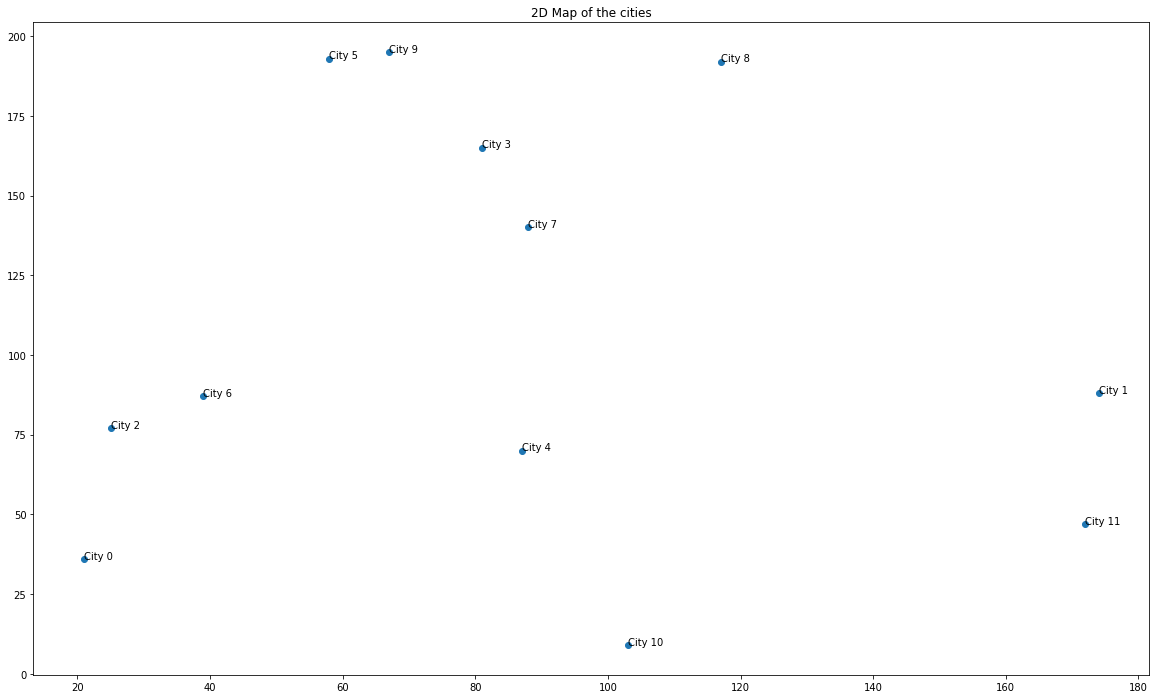

In [50]:
simulation.plot_cities_map()

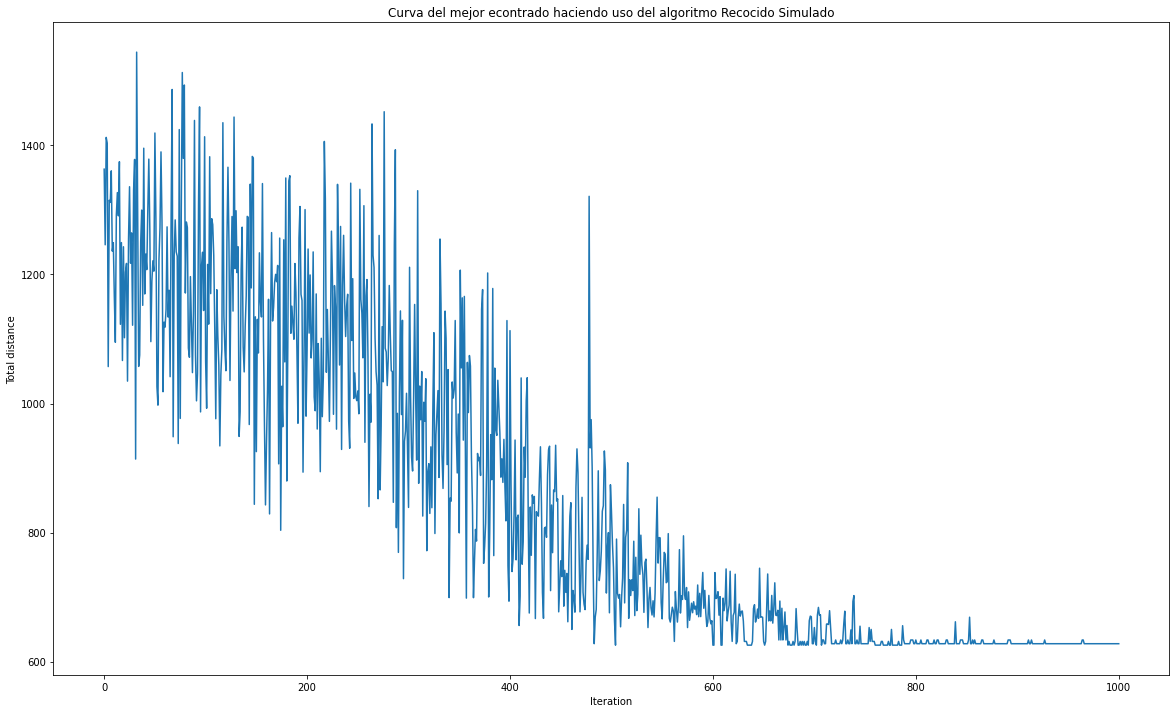

<Figure size 432x288 with 0 Axes>

In [51]:
simulation.plot_best_historic()